<a href="https://colab.research.google.com/github/sukhyun1017/quantum/blob/main/QAOA%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [ ]:
pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from pennylane import numpy as np
import pennylane as qml

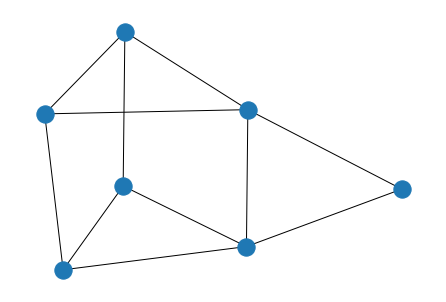

In [ ]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [ ]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, interface="tf", diff_method="backprop")

        return cost(params)
    
    return hamiltonian

In [ ]:
cost

<function __main__.qaoa_from_graph.<locals>.hamiltonian>

In [ ]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.

print(cost(x))

tf.Tensor(-3.193267957255579, shape=(), dtype=float64)


In [ ]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [ ]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

In [ ]:
graph_cost_list[0]

<function __main__.qaoa_from_graph.<locals>.hamiltonian>

In [ ]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]

def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):

    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)
    out5 = rnn_iteration(out4, graph_cost)
    out6 = rnn_iteration(out5, graph_cost)
    out7 = rnn_iteration(out6, graph_cost)
    out8 = rnn_iteration(out7, graph_cost)
    out9 = rnn_iteration(out8, graph_cost)

    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0],
         0.6*out5[0], 0.7 * out6[0], 0.8 * out7[0], 0.9 * out8[0],1*out9[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1],out5[1],
                out6[1], out7[1], out8[1], out9[1], loss]
    else:
        return loss

In [ ]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [ ]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: -3.9287872314453125
 > Graph 6/20 - Loss: -2.732701301574707
 > Graph 11/20 - Loss: -2.5562689304351807
 > Graph 16/20 - Loss: -2.3937952518463135
 >> Mean Loss during epoch: -3.348723316192627
Epoch 2
 > Graph 1/20 - Loss: -3.9245998859405518
 > Graph 6/20 - Loss: -2.683635711669922
 > Graph 11/20 - Loss: -2.555223226547241
 > Graph 16/20 - Loss: -2.399951457977295
 >> Mean Loss during epoch: -3.3637635469436646
Epoch 3
 > Graph 1/20 - Loss: -3.9288902282714844
 > Graph 6/20 - Loss: -2.7083420753479004
 > Graph 11/20 - Loss: -2.559394598007202
 > Graph 16/20 - Loss: -2.4154791831970215
 >> Mean Loss during epoch: -3.3658087611198426
Epoch 4
 > Graph 1/20 - Loss: -3.927346706390381
 > Graph 6/20 - Loss: -2.733638286590576
 > Graph 11/20 - Loss: -2.565610408782959
 > Graph 16/20 - Loss: -2.4247488975524902
 >> Mean Loss during epoch: -3.3636858224868775
Epoch 5
 > Graph 1/20 - Loss: -3.9176993370056152
 > Graph 6/20 - Loss: -2.7429866790771484
 > Graph 11/2

In [ ]:
print(len(total_loss))

20


Results
=======

Let's see how to use the optimized RNN as an initializer for the angles
in the QAOA algorithm.

First, we pick a new graph, not present in the training dataset:


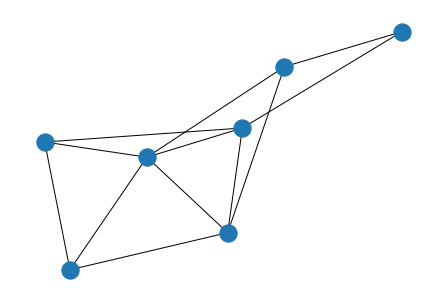

In [ ]:
new_graph = nx.gnp_random_graph(7, p=3 /7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

![](../demonstrations/learning2learn/rendered_Graph1.png){.align-center
width="70.0%"}


In [ ]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
guess_5 = res[5]
guess_6 = res[6]
guess_7 = res[7]
guess_8 = res[8]
guess_9 = res[9]


# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4,guess_5, guess_6, guess_7, guess_8, guess_9]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

**Plot of the loss function**

We can plot these losses to see how well the RNN proposes new guesses
for the parameters.


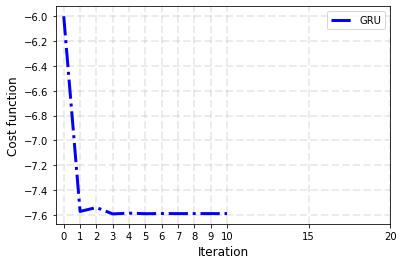

In [ ]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="GRU")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0,1,2,3,4, 5,6,7,8,9, 10, 15,20]);
plt.show()

![](../demonstrations/learning2learn/rendered_LossLSTM.png){.align-center
width="70.0%"}

That's remarkable! The RNN learned to propose new parameters such that
the MaxCut cost is minimized very rapidly: in just a few iterations the
loss reaches a minimum. Actually, it takes just a single step for the
LSTM to find a very good minimum. In fact, due to the recurrent loop,
the loss in each time step is directly dependent on the previous ones,
with the first iteration thus having a lot of influence on the loss
function defined above. Changing the loss function, for example giving
less importance to initial steps and just focusing on the last one,
leads to different optimization behaviors, but with the same final
results.


**Comparison with standard Stochastic Gradient Descent (SGD)**

How well does this method compare with standard optimization techniques,
for example, leveraging Stochastic Gradient Descent (SGD) to optimize
the parameters in the QAOA?

Let's check it out.


In [ ]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = -5.913072549973541
Step 2 - Loss = -6.032698711409235
Step 3 - Loss = -6.117030150620711
Step 4 - Loss = -6.1909314634947155
Step 5 - Loss = -6.268833709902699
Step 6 - Loss = -6.3584636097410545
Step 7 - Loss = -6.46313899160424
Step 8 - Loss = -6.582574959488724
Step 9 - Loss = -6.713106644938809
Step 10 - Loss = -6.848218668316924
Step 11 - Loss = -6.979890991590256
Step 12 - Loss = -7.1005860991642615
Step 13 - Loss = -7.205068730566607
Step 14 - Loss = -7.29122467827248
Step 15 - Loss = -7.359689693161915
Final cost function: -7.412787832573892
Optimized angles: [[0.35067563]
 [1.1875493 ]]


In [ ]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
step = 15

# Training process
steps = []
adam_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    adam_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = -3.9516529264319766
Step 2 - Loss = -4.651069863617681
Step 3 - Loss = -5.328700191210625
Step 4 - Loss = -5.821742436459908
Step 5 - Loss = -6.084954262822476
Step 6 - Loss = -6.178105455921722
Step 7 - Loss = -6.187896476966093
Step 8 - Loss = -6.170483846667304
Step 9 - Loss = -6.149199031215814
Step 10 - Loss = -6.130228073571655
Step 11 - Loss = -6.113618278168336
Step 12 - Loss = -6.098352027823588
Step 13 - Loss = -6.084415329632937
Step 14 - Loss = -6.073640107861632
Step 15 - Loss = -6.069958237136534
Final cost function: -6.079211669723542
Optimized angles: [[ 1.24188951]
 [-0.60769869]]


In [ ]:
cost

<function __main__.qaoa_from_graph.<locals>.hamiltonian>

In [ ]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = qml.QNGOptimizer(0.01)
step = 15

# Training process

qng_losses = []
for _ in range(step):
    x= opt.step(wires=1, device='default.qubit.autograd', interface='autograd', diff_method='best', x)
    qng_losses.append(new_cost(x))

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

In [ ]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = qml.QNGOptimizer(0.01)
step = 15

# Training process
steps = []
RMSprop_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    RMSprop_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

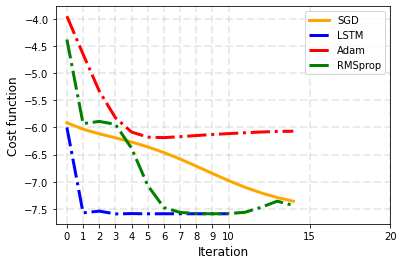

In [ ]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.plot(adam_losses, color="red", lw=3, ls="-.", label="Adam")

plt.plot(RMSprop_losses, color="green", lw=3, ls="-.", label="RMSprop")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0,1,2,3,4, 5,6,7,8,9, 10, 15, 20]);
plt.show()

![](../demonstrations/learning2learn/rendered_LossConfrontation.png){.align-center
width="70.0%"}


Final remarks
=============

In this demo, we saw how to use a recurrent neural network as a
black-box optimizer to initialize the parameters in a variational
quantum circuit close to an optimal solution. We connected MaxCut QAOA
quantum circuits in PennyLane with an LSTM built with TensorFlow, and we
used a custom hybrid training routine to optimize the whole network.

Such architecture proved itself to be a good candidate for the
initialization problem of Variational Quantum Algorithms, since it
reaches good optimal solutions in very few iterations. Besides, the
architecture is quite general since the same machinery can be used for
graphs having a generic number of nodes (see \"Generalization
Performances\" in the Appendix).

**What's next?**

But the story does not end here. There are multiple ways this work could
be improved. Here are a few:

-   Use the proposed architecture for VQAs other than QAOA for MaxCut.
    You can check the paper to get some inspiration.
-   Scale up the simulation, using bigger graphs and longer recurrent
    loops.
-   While working correctly, the training routine is quite basic and it
    could be improved for example by implementing batch learning or a
    stopping criterion. Also, one could implement the *observed
    improvement* loss function, as used in the original paper .
-   Depending on the problem, you may wish to transform the functions
    `rnn_iteration` and `recurrent_loop` to actual `Keras Layers` and
    `Models`. This way, by compiling the model before the training takes
    place, `TensorFlow` can create the computational graph of the model
    and train more efficiently. You can find some ideas below to start
    working on it.

If you\'re interested, in the Appendix below you can find some more
details and insights about this model. Go check it out!

If you have any doubt, or wish to discuss about the project don't
hesitate to contact me, I'll be very happy to help you as much as I can
😁

Have a great quantum day!


References
==========


Appendix
========

In this appendix you can find further details about the Learning to
Learn approach introduced in this tutorial.

Generalization performances
---------------------------

A very interesting feature of this model, is that it can be
straightforwardly applied to graphs having a different number of nodes.
In fact, until now our analysis focused only on graphs with the same
number of nodes for ease of explanation, and there is no actual
restriction in this respect. The same machinery works fine for any
graph, since the number of QAOA parameters are only dependent on the
number of layers in the ansatz, and not on the number of qubits (equal
to the number of nodes in the graph) in the quantum circuit.

Thus, we might want to challenge our model to learn a good
initialization heuristic for a non-specific graph, with an arbitrary
number of nodes. For this purpose, let's create a training dataset
containing graphs with a different number of nodes $n$, taken in the
interval $n \in [7,9]$ (that is, our dataset now contains graphs having
either 7, 8 and 9 nodes).


In [ ]:
def rnn_iteration(inputs, graph_cost, n_layers=1):

    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    _params = tf.reshape(new_params, shape=(2, n_layers))

    _cost = graph_cost(_params)

    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]

def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):

    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)
    out5 = rnn_iteration(out4, graph_cost)
    out6 = rnn_iteration(out5, graph_cost)
    out7 = rnn_iteration(out6, graph_cost)
    out8 = rnn_iteration(out7, graph_cost)
    out9 = rnn_iteration(out8, graph_cost)
    out10 = rnn_iteration(out0, graph_cost)
    out11 = rnn_iteration(out1, graph_cost)
    out12 = rnn_iteration(out2, graph_cost)
    out13 = rnn_iteration(out3, graph_cost)
    out14 = rnn_iteration(out4, graph_cost)
    out15 = rnn_iteration(out5, graph_cost)
    out16 = rnn_iteration(out6, graph_cost)
    out17 = rnn_iteration(out7, graph_cost)
    out18 = rnn_iteration(out8, graph_cost)
    out19 = rnn_iteration(out8, graph_cost)

    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0],
         0.6*out5[0], 0.7 * out6[0], 0.8 * out7[0], 0.9 * out8[0],1*out9[0],1.1 * out10[0], 1.2 * out11[0], 1.3 * out12[0], 1.4 * out13[0], 1.5 * out14[0],
         1.6*out15[0], 1.7 * out16[0], 1.8 * out17[0], 1.9 * out18[0],2*out19[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1],out5[1],
                out6[1], out7[1], out8[1], out9[1],out10[1], out11[1], out12[1], out13[1], out14[1],out15[1],
                out16[1], out17[1], out18[1], out19[1], loss]
    else:
        return loss

In [ ]:
cell = tf.keras.layers.LSTMCell(2 * n_layers)

g7 = generate_graphs(3, 10, 3 / 11)
g8 = generate_graphs(3, 9, 3 / 9)
g9 = generate_graphs(3, 11, 3 / 11)

gs = g7 + g8 + g9
gs_cost_list = [qaoa_from_graph(g) for g in gs]

# Shuffle the dataset
import random
random.seed(1234)
random.shuffle(gs_cost_list)

So far, we have created an equally balanced dataset that contains graphs
with a different number of nodes. We now use this dataset to train the
LSTM.


In [ ]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(gs_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(gs_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/9 - Loss: [[-1.7869866]]
 > Graph 6/9 - Loss: [[-4.234027]]
 >> Mean Loss during epoch: -3.778327544530233
Epoch 2
 > Graph 1/9 - Loss: [[-2.4545856]]
 > Graph 6/9 - Loss: [[-4.8843393]]
 >> Mean Loss during epoch: -4.229445987277561
Epoch 3
 > Graph 1/9 - Loss: [[-2.4904542]]
 > Graph 6/9 - Loss: [[-4.9021945]]
 >> Mean Loss during epoch: -4.2912065452999535


::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
Epoch 1
> Graph 1/15 - Loss: [[-1.4876363]]
> Graph 6/15 - Loss: [[-1.8590403]]
> Graph 11/15 - Loss: [[-1.7644017]]
>> Mean Loss during epoch: -1.9704322338104248
Epoch 2
> Graph 1/15 - Loss: [[-1.8650053]]
> Graph 6/15 - Loss: [[-1.9578737]]
> Graph 11/15 - Loss: [[-1.8377447]]
>> Mean Loss during epoch: -2.092947308222453
Epoch 3
> Graph 1/15 - Loss: [[-1.9009062]]
> Graph 6/15 - Loss: [[-1.9726204]]
> Graph 11/15 - Loss: [[-1.8668792]]
>> Mean Loss during epoch: -2.1162660201390584
```
:::


Let's check if this hybrid model eventually learned a good heuristic to
propose new updates for the parameters in the QAOA ansatz of the MaxCut
problem.

For this reason, we consider a new graph. In particular, we can take a
graph with 10 nodes, which is something that the recurrent network has
not seen before.


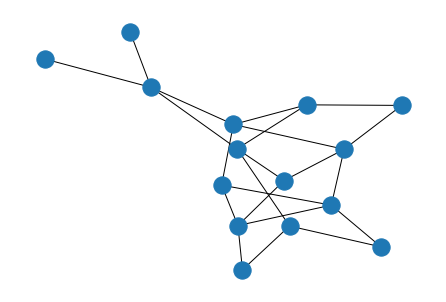

In [ ]:
new_graph = nx.gnp_random_graph(15, p=3 / 15)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

![](../demonstrations/learning2learn/rendered_Graph10.png){.align-center
width="70.0%"}


We call the trained recurrent LSTM on this graph, saving not only the
last, but all intermediate guesses for the parameters.


In [ ]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
guess_5 = res[5]
guess_6 = res[6]
guess_7 = res[7]
guess_8 = res[8]
guess_9 = res[9]


# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4,guess_5, guess_6, guess_7, guess_8, guess_9]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

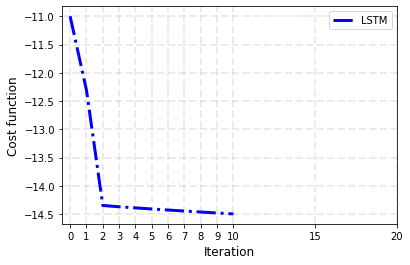

In [ ]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0,1,2,3,4, 5,6,7,8,9, 10, 15,20]);
plt.show()

![](../demonstrations/learning2learn/rendered_LossGeneralization.png){.align-center
width="70.0%"}


Again, we can confirm that the custom optimizer based on the LSTM
quickly reaches a good value of the loss function, and also achieve good
generalization performances, since it is able to initialize parameters
also for graphs not present in the training set.

::: {.note}
::: {.title}
Note
:::

To get the optimized weights of the LSTM use:
`optimized_weights = cell.get_weights()`. To set initial weights for the
LSTM cell, use instead: `cell.set_weights(optimized_weights)`.
:::

Loss landscape in parameter space
=================================

It may be interesting to plot the path suggested by the RNN in the space
of the parameters. Note that this is possible only if one layer is used
in the QAOA ansatz since in this case only two angles are needed and
they can be plotted on a 2D plane. Of course, if more layers are used,
you can always select a pair of them to reproduce a similar plot.

::: {.note}
::: {.title}
Note
:::

This cell takes approx. \~1m to run with an 11 by 11 grid
:::


In [ ]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1.0, 1.0, 11)
dz = np.array([new_cost([[xx], [yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11, 11))

# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [res[i].numpy()[0, 0] for i in range(len(res[:-1]))]
params_y = [res[i].numpy()[0, 1] for i in range(len(res[:-1]))]

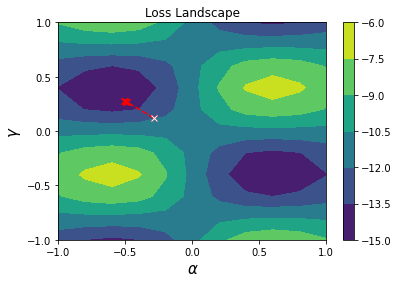

In [ ]:
# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [res[i].numpy()[0, 0] for i in range(len(res[:-1]))]
params_y = [res[i].numpy()[0, 1] for i in range(len(res[:-1]))]
# Plot steps
plt.plot(params_x[0:], params_y[0:], linestyle="--", color="red", marker="x")
plt.plot(params_x[0], params_y[0], linestyle="--", color="white", marker="x")

plt.yticks(np.linspace(-1, 1, 5))
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel(r"$\gamma$", fontsize=15)
plt.title("Loss Landscape", fontsize=12)
plt.show()